In [119]:
import pickle
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import fcluster
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [120]:
df = pd.read_csv('fake_data.csv')

In [121]:
trainingdata = df.drop(columns=['Project_ID', 'Project_Name', 'At_Risk'])

def additional_values(df):

    df['Budget_Deviation'] = df['%_Budget_Used'] - df['%_Work_Completed']
    df['Timeline_Deviation'] = df['%_Timeline_Completed'] - df['%_Work_Completed']
    df['Workload_Per_Team_Member'] = df['Estimated_Hours'] / (df['Team_Size'] * df['Timeline_Days'])
    df['Workload_Feature'] = df['Estimated_Hours'] / df['Timeline_Days']
    df['Team_Size_Adjusted_Workload'] = df['Workload_Feature'] / df['Team_Size']
    return df

def preprocessing(df):

    num_cols = ['Budget', 'Estimated_Hours', 'Timeline_Days', 'Team_Size', '%_Budget_Used', '%_Work_Completed', '%_Timeline_Completed', 'Budget_Deviation', 'Timeline_Deviation','Workload_Per_Team_Member', 'Workload_Feature', 'Team_Size_Adjusted_Workload']
    num_pipeline = Pipeline([("impuder", SimpleImputer(strategy='mean')), ("scale", RobustScaler())])

# Combine with ColumnTransformer
    preprocess = ColumnTransformer(transformers=[
        ('num_vals', num_pipeline, num_cols)]) 
    #transform the data
    x_transformed = preprocess.fit_transform(df)

    all_columns = num_cols

    transformed_df = pd.DataFrame(x_transformed, columns=all_columns)

    return transformed_df, preprocess



In [122]:
new_df = additional_values(trainingdata)
transformed_df, preprocess =preprocessing(new_df)
transformed_df['At_Risk'] = df['At_Risk'].values

# Define thresholds for workload
threshold_workload_per_person = 2
threshold_team_size_adjusted_workload = 2

# Update labels conditionally
transformed_df["At_Risk_Updated"] = transformed_df["At_Risk"]  # Start with existing labels
transformed_df.loc[
    (transformed_df["Workload_Per_Team_Member"] > threshold_workload_per_person) |
    (transformed_df["Team_Size_Adjusted_Workload"] > threshold_team_size_adjusted_workload),
    "At_Risk_Updated"
] = 1

# Check where labels changed
changed_labels = transformed_df[transformed_df["At_Risk"] != transformed_df["At_Risk_Updated"]]
print("Projects where labels were updated based on workload:")
print(changed_labels)


Projects where labels were updated based on workload:
       Budget  Estimated_Hours  Timeline_Days  Team_Size  %_Budget_Used  \
107 -0.568352         0.700744      -0.973312   0.555556       0.485981   
117  0.289149         0.307692      -1.023548  -0.222222      -0.037383   

     %_Work_Completed  %_Timeline_Completed  Budget_Deviation  \
107               0.0                   0.0          0.335766   
117               0.0                   0.0         -0.277372   

     Timeline_Deviation  Workload_Per_Team_Member  Workload_Feature  \
107           -0.051282                  2.486801          4.291872   
117           -0.051282                  4.845806          3.941716   

     Team_Size_Adjusted_Workload  At_Risk  At_Risk_Updated  
107                     2.486801        0                1  
117                     4.845806        0                1  


In [123]:
# Inspect workload-related features
print(transformed_df[["Workload_Per_Team_Member", "Team_Size_Adjusted_Workload"]].describe())


       Workload_Per_Team_Member  Team_Size_Adjusted_Workload
count                120.000000                   120.000000
mean                   0.541048                     0.541048
std                    1.655575                     1.655575
min                   -0.663921                    -0.663921
25%                   -0.332308                    -0.332308
50%                    0.000000                     0.000000
75%                    0.667692                     0.667692
max                   10.506075                    10.506075


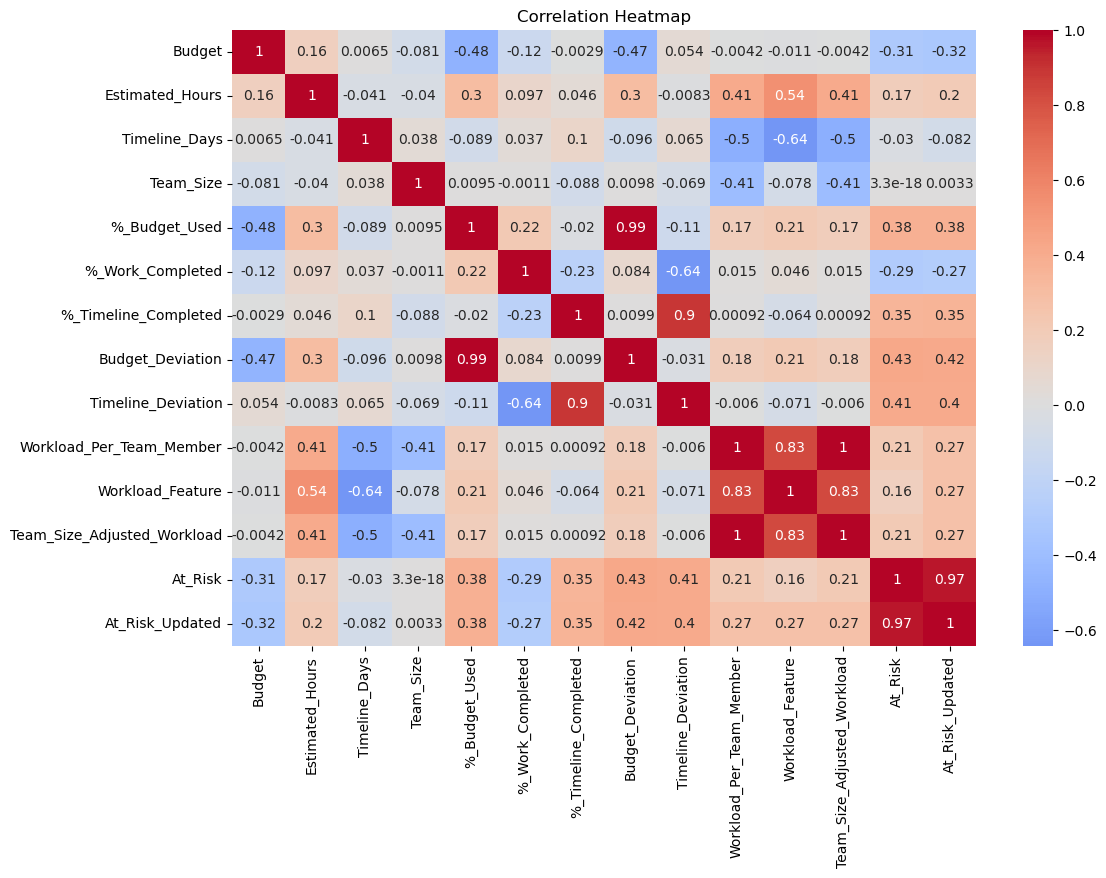

In [124]:


corr_matrix = transformed_df.corr()
#plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix,annot=True ,cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

In [125]:
inertia = []
cluster_range = range(1, 11)

for i in cluster_range:
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(transformed_df)
    inertia.append(kmeans.inertia_)

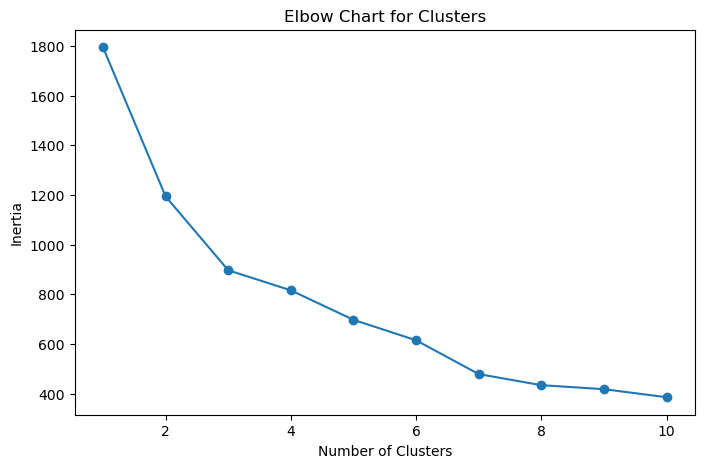

In [126]:
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Chart for Clusters')
plt.show()

In [127]:
best_clusters = 3
kmeans = KMeans(n_clusters=best_clusters, random_state=42)
kmeans.fit(transformed_df)
cluster_labels = kmeans.labels_
transformed_df['Cluster'] = cluster_labels

In [128]:
cluster_means = transformed_df.groupby('Cluster').mean()
print("Cluster Means:\n", cluster_means)

Cluster Means:
            Budget  Estimated_Hours  Timeline_Days  Team_Size  %_Budget_Used  \
Cluster                                                                       
0        0.092835        -0.068271       0.073800   0.161512       0.010149   
1       -0.678328         0.158313       0.025641   0.083333       3.548287   
2        0.013732         0.550056      -0.864279  -0.303030       0.632116   

         %_Work_Completed  %_Timeline_Completed  Budget_Deviation  \
Cluster                                                             
0               -0.555616             -0.028245         -0.067575   
1               -0.333333             -0.107306          4.015815   
2               -0.578947              0.042341          0.667551   

         Timeline_Deviation  Workload_Per_Team_Member  Workload_Feature  \
Cluster                                                                   
0                  0.192969                  0.050784          0.068893   
1                

In [129]:
linkage_matrix = linkage(transformed_df, method='ward')

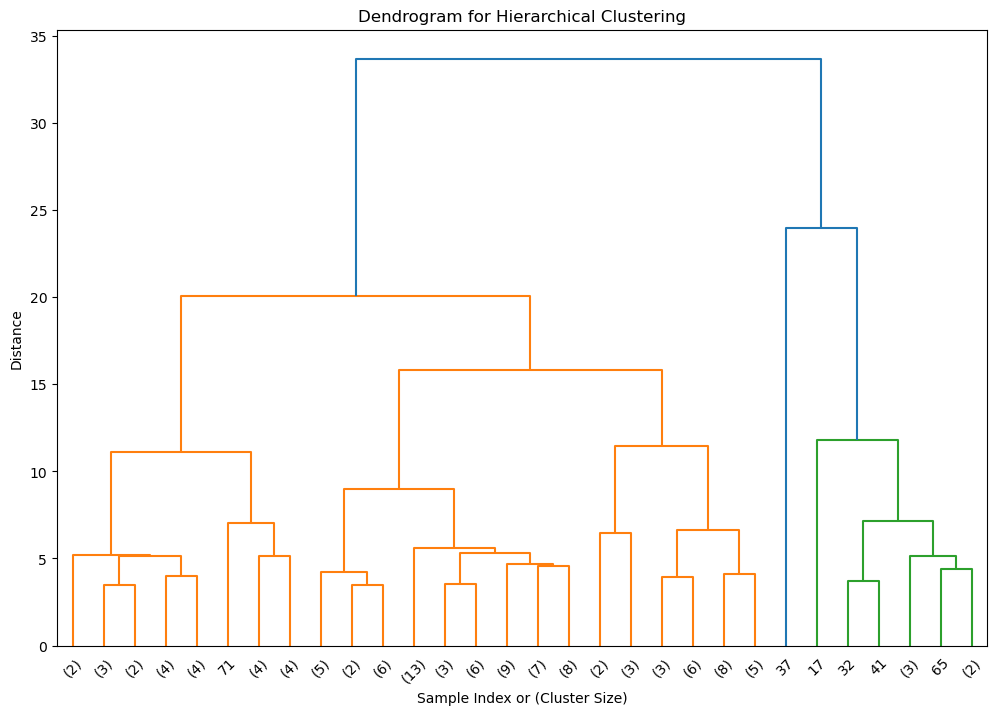

In [130]:
plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix, truncate_mode='lastp', p=30, leaf_rotation=45, leaf_font_size=10)
plt.title("Dendrogram for Hierarchical Clustering")
plt.xlabel("Sample Index or (Cluster Size)")
plt.ylabel("Distance")
plt.show()

In [131]:
optimal_clusters = 3
cluster_labels = fcluster(linkage_matrix, optimal_clusters, criterion='maxclust')

transformed_df['Hierarchical_Cluster'] = cluster_labels

In [132]:
# sns.pairplot(transformed_df.drop(columns='Cluster', axis=1), hue='Hierarchical_Cluster', palette='dark', markers='o', plot_kws={'s': 40})
# plt.suptitle('Pair Plot of Clusters Across Features', y=1.02)
# plt.show()

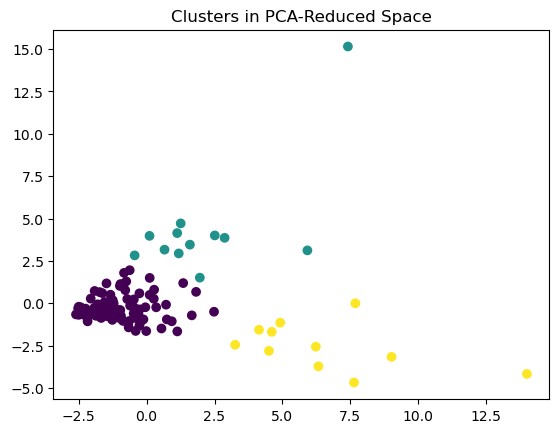

In [133]:
pca = PCA(n_components=2)
pca_features = pca.fit_transform(transformed_df)

plt.scatter(pca_features[:, 0], pca_features[:, 1], c=transformed_df['Cluster'], cmap='viridis')
plt.title('Clusters in PCA-Reduced Space')
plt.show()


In [134]:
cluster_profiles = transformed_df.drop(columns=['Hierarchical_Cluster']).groupby('Cluster').mean()
print(cluster_profiles)


           Budget  Estimated_Hours  Timeline_Days  Team_Size  %_Budget_Used  \
Cluster                                                                       
0        0.092835        -0.068271       0.073800   0.161512       0.010149   
1       -0.678328         0.158313       0.025641   0.083333       3.548287   
2        0.013732         0.550056      -0.864279  -0.303030       0.632116   

         %_Work_Completed  %_Timeline_Completed  Budget_Deviation  \
Cluster                                                             
0               -0.555616             -0.028245         -0.067575   
1               -0.333333             -0.107306          4.015815   
2               -0.578947              0.042341          0.667551   

         Timeline_Deviation  Workload_Per_Team_Member  Workload_Feature  \
Cluster                                                                   
0                  0.192969                  0.050784          0.068893   
1                  0.010684      

In [135]:
from sklearn.cluster import KMeans

# Perform clustering
kmeans = KMeans(n_clusters=3, random_state=42)
transformed_df['Cluster'] = kmeans.fit_predict(transformed_df.drop(columns=['At_Risk']))

In [136]:
pd.crosstab(transformed_df['Cluster'], transformed_df['At_Risk'])

At_Risk,0,1
Cluster,,
0,59,38
1,0,12
2,2,9


In [137]:
transformed_df.columns

Index(['Budget', 'Estimated_Hours', 'Timeline_Days', 'Team_Size',
       '%_Budget_Used', '%_Work_Completed', '%_Timeline_Completed',
       'Budget_Deviation', 'Timeline_Deviation', 'Workload_Per_Team_Member',
       'Workload_Feature', 'Team_Size_Adjusted_Workload', 'At_Risk',
       'At_Risk_Updated', 'Cluster', 'Hierarchical_Cluster'],
      dtype='object')

In [138]:
X = transformed_df.drop(columns=['At_Risk', 'Cluster', 'Hierarchical_Cluster','At_Risk_Updated'])
y = transformed_df['At_Risk_Updated']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [139]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           1       1.00      0.93      0.96        14

    accuracy                           0.96        24
   macro avg       0.95      0.96      0.96        24
weighted avg       0.96      0.96      0.96        24



In [140]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
print("Cross-validation scores:", scores)
print("Mean accuracy:", scores.mean())


Cross-validation scores: [1.         1.         0.95833333 1.         0.91666667]
Mean accuracy: 0.975


In [ ]:
# Example single project data (replace with actual values)
new_project = {
    "Budget": 10000,
    "Estimated_Hours": 2000,
    "Timeline_Days": 10,
    "Team_Size": 1,
    "%_Budget_Used": 0.0,
    "%_Work_Completed": 0.0,
    "%_Timeline_Completed": 0.0
}


In [ ]:
model.

In [ ]:
def single_project_test(new_project, model=model):
    new_project_df = pd.DataFrame([new_project])
    new_project_w_adds = additional_values(new_project_df)
    new_project_transformed=preprocess.transform(new_project_w_adds)
    all_columns = ['Budget', 'Estimated_Hours', 'Timeline_Days', 'Team_Size', '%_Budget_Used', '%_Work_Completed', '%_Timeline_Completed', 'Budget_Deviation', 'Timeline_Deviation', 'Workload_Per_Team_Member', 'Workload_Feature', 'Team_Size_Adjusted_Workload']
    new_project_transformed_df = pd.DataFrame(new_project_transformed, columns=all_columns)
    risk_prediction = model.predict(new_project_transformed_df)
    risk_probability = model.predict_proba(new_project_transformed_df)

    print(f"Risk Prediction: {'At Risk' if risk_prediction[0] == 1 else 'Not At Risk'}")
    print(f"Probability of Being At Risk: {risk_probability[0][1]:.2f}")

    return new_project_transformed_df


In [150]:
new_project_transformed_df = single_project_test(new_project)

Risk Prediction: At Risk
Probability of Being At Risk: 0.68
